<a href="https://colab.research.google.com/github/p25-c4/kerly_project/blob/main/0315_HY_RFM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setting

In [ ]:
!nvidia-smi

Fri Mar 15 13:32:32 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [1]:
!apt-get update -qq
!apt-get install fonts-nanum* -qq
!rm ~/.cache/matplotlib -rf

Selecting previously unselected package fonts-nanum.
(Reading database ... 121752 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Selecting previously unselected package fonts-nanum-coding.
Preparing to unpack .../fonts-nanum-coding_2.5-3_all.deb ...
Unpacking fonts-nanum-coding (2.5-3) ...
Selecting previously unselected package fonts-nanum-eco.
Preparing to unpack .../fonts-nanum-eco_1.000-7_all.deb ...
Unpacking fonts-nanum-eco (1.000-7) ...
Selecting previously unselected package fonts-nanum-extra.
Preparing to unpack .../fonts-nanum-extra_20200506-1_all.deb ...
Unpacking fonts-nanum-extra (20200506-1) ...
Setting up fonts-nanum-extra (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Setting up fonts-nanum-coding (2.5-3) ...
Setting up fonts-nanum-eco (1.000-7) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...


In [1]:
# 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir("/content/drive/MyDrive/BigData/early_project")

In [3]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# 한글폰트 설정
mpl.rc("font",family = "NanumGothic")
mpl.rc("axes", unicode_minus = False)

# Data load

In [5]:
users = pd.read_csv("on_users.csv", encoding='cp949')
print(users.shape)
users.head()

(3000, 5)


,idUser,Gender,Age,FamilyCount,MemberYN
0,U10001,여성,26,2,Y
1,U10002,남성,61,2,Y
2,U10003,여성,34,2,Y
3,U10004,남성,26,1,N
4,U10005,여성,33,3,Y


In [6]:
orders = pd.read_csv("on_orders.csv", encoding='cp949')
print(orders.shape)
orders.head()

(1043272, 6)


,idUser,idOrder,OrderDT,ItemCode,Price,DeliveryDT
0,U10001,U10001-O2021-1001,03DEC2021:20:59:27,L1-M12-S0070-1113,17030,04DEC2021:03:26:00
1,U10001,U10001-O2021-1001,03DEC2021:20:59:27,L1-M15-S0140-1247,7680,04DEC2021:03:26:00
2,U10001,U10001-O2021-1001,03DEC2021:20:59:27,L1-M23-S0580-1047,12420,04DEC2021:03:26:00
3,U10001,U10001-O2021-1001,03DEC2021:20:59:27,L4-M12-S0640-1010,6250,04DEC2021:03:26:00
4,U10001,U10001-O2021-1001,03DEC2021:20:59:27,L4-M17-S0130-1018,14450,04DEC2021:03:26:00


In [7]:
items = pd.read_csv("on_items.csv", encoding='utf-8')
print(items.shape)
items.head()

(11019, 11)


,ItemLargeCode,ItemLargeName,ItemMiddleCode,ItemMiddleName,ItemSmallCode,ItemSmallName,ItemCode,ItemName,PriceYear,PriceMin,PriceMax
0,L1,가공식품,M11,곡물,S0080,국수,L1-M11-S0080-1001,(식품)샘표 김치국수 101g 10입(가공식품),2021,15840,16130
1,L1,가공식품,M11,곡물,S0080,국수,L1-M11-S0080-1001,(식품)샘표 김치국수 101g 10입(가공식품),2022,17030,17340
2,L1,가공식품,M11,곡물,S0080,국수,L1-M11-S0080-1001,(식품)샘표 김치국수 101g 10입(가공식품),2023,17380,18640
3,L1,가공식품,M11,곡물,S0080,국수,L1-M11-S0080-1002,2.1kg 6배 메밀 Bestco 희석용 소바 국수장국,2022,14160,15350
4,L1,가공식품,M11,곡물,S0080,국수,L1-M11-S0080-1002,2.1kg 6배 메밀 Bestco 희석용 소바 국수장국,2023,15060,16160


## order에 Delay_YN 열 추가

In [8]:
# OrderDT와 DeliveryDT 타입 변경
orders['OrderDT'] = pd.to_datetime(orders['OrderDT'], format='%d%b%Y:%H:%M:%S')
orders['DeliveryDT'] = pd.to_datetime(orders['DeliveryDT'], format='%d%b%Y:%H:%M:%S')
# DeliveryDT가 오전 7시보다 늦으면 'Y', 이전이면 'N'인 파생 변수 생성
orders['Delay_YN'] = orders['DeliveryDT'].dt.hour >= 7
orders['Delay_YN'] = orders['Delay_YN'].map({True: 1, False: 0}) # 지연: 1, 지연X: 0

## order와 item 합치기

In [9]:
## order와 item 합치기
# items에서 PriceYear, PriceMax, PriceMin 제거 --> 중복된 data가 들어가는 것을 막기 위함
items_NoPrice = items.iloc[:,:-3]

order_item_df = pd.merge(orders, items_NoPrice, on='ItemCode', how='left')

# 병합된 데이터프레임의 처음 몇 행을 출력하여 확인
order_item_df = order_item_df.drop_duplicates(ignore_index= True)
print(order_item_df.shape)
order_item_df.head()

(1043272, 14)


,idUser,idOrder,OrderDT,ItemCode,Price,DeliveryDT,Delay_YN,ItemLargeCode,ItemLargeName,ItemMiddleCode,ItemMiddleName,ItemSmallCode,ItemSmallName,ItemName
0,U10001,U10001-O2021-1001,2021-12-03 20:59:27,L1-M12-S0070-1113,17030,2021-12-04 03:26:00,0,L1,가공식품,M12,과일,S0070,과일,이츠웰 후르츠칵테일 과일통조림 3K 슬라이스
1,U10001,U10001-O2021-1001,2021-12-03 20:59:27,L1-M15-S0140-1247,7680,2021-12-04 03:26:00,0,L1,가공식품,M15,냉동,S0140,냉동,베지가든 수제교자만두 매콤한 김치맛 720g (360gx2개입)
2,U10001,U10001-O2021-1001,2021-12-03 20:59:27,L1-M23-S0580-1047,12420,2021-12-04 03:26:00,0,L1,가공식품,M23,축산,S0580,치즈,매일유업 매일 상하치즈 피자용 모짜렐라 슈레드치즈 200gx5봉
3,U10001,U10001-O2021-1001,2021-12-03 20:59:27,L4-M12-S0640-1010,6250,2021-12-04 03:26:00,0,L4,신선식품,M12,과일,S0640,토마,[계양구 배달] 싱싱한 방울토마토 750g [작전 과일나라]
4,U10001,U10001-O2021-1001,2021-12-03 20:59:27,L4-M17-S0130-1018,14450,2021-12-04 03:26:00,0,L4,신선식품,M17,수산,S0130,낙지,낙지호롱 900g 20-25개 낙지꼬치구이 냉동낙지 (양념소스70gx1팩 제공)


# check the data

## 결측치 및 이상치 탐지

In [ ]:
# 결측치 탐지(결측치 없음)
print(orders.isnull().sum(),
      users.isnull().sum(),
      items.isnull().sum())

idUser        0
idOrder       0
OrderDT       0
ItemCode      0
Price         0
DeliveryDT    0
Delay_YN      0
dtype: int64 idUser         0
Gender         0
Age            0
FamilyCount    0
MemberYN       0
dtype: int64 ItemLargeCode     0
ItemLargeName     0
ItemMiddleCode    0
ItemMiddleName    0
ItemSmallCode     0
ItemSmallName     0
ItemCode          0
ItemName          0
PriceYear         0
PriceMin          0
PriceMax          0
dtype: int64


최소 나이:  21 
 최대 나이:  69
최소 구성원 수:  0 
 최대 구성원 수:  3


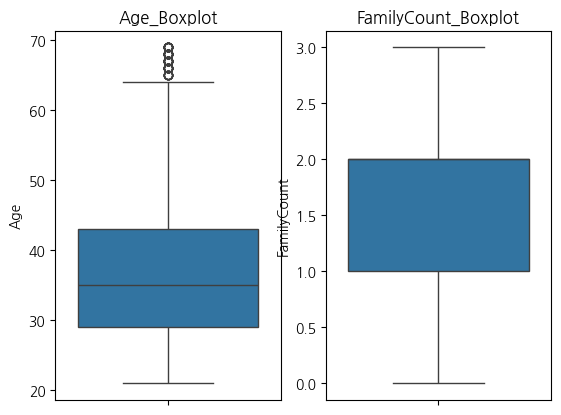

In [ ]:
# 이상치 탐지(나이, 가족 구성원 수) --> 이상치 없음
plt.subplots(ncols=2)

plt.subplot(121)
sns.boxplot(data = users, y = 'Age')
plt.title("Age_Boxplot")
print("최소 나이: ", np.min(users['Age']), "\n", "최대 나이: ", np.max(users['Age']))

plt.subplot(122)
sns.boxplot(data = users, y = 'FamilyCount')
plt.title("FamilyCount_Boxplot")
print("최소 구성원 수: ", np.min(users['FamilyCount']), "\n", "최대 구성원 수: ", np.max(users['FamilyCount']))


In [ ]:
# 주문에서 대분류 비율 확인("신선식품", "가공식품", "생수", "음료")
order_item_df['ItemLargeName'].value_counts(normalize=True)

신선식품    0.515327
가공식품    0.464597
음료      0.015895
생수      0.004181
Name: ItemLargeName, dtype: float64

# preprocessing

## not_food 처리

In [10]:
# list of not food --> 시간 오래 걸렸음
not_food = ["냄비", "기계", "디스펜서", "퍼즐", "냉장고", "밀폐용기",
            "액자", "수동 반죽펴기", "채칼", "캔따기", "모자",
            "카지노","용기","케이스","만두통", "바람개비", "레깅스", "수박 나무라고요",
            "스텐 상추바구니 2호 야채 튀김 과일 바스켓 채반",
            "스테인레스 상추바구니 1호 메쉬바구니 소쿠리 채반",
            "스텐 타공상추바구니 2호","수박과도 大 (10개묶음) 0151","양상추 1cm 샌들 슬리퍼  JG6 (7157830)",
            "후르츠커버포켓크로스백(수박)", "양상추 여름 블라우스 JAP60 (7271217)", "양상추 여자 슬랙스 BF33 (7416269)",
            "양상추 여자 여름샌들 JK131 (7162818)", "MT124 A4 참외색 매직터치 두성 180g 10매입 X ( 3세트 )",
            "에이프릴래빗 양상추 스트링 빅포켓 숏야상점퍼 MA0906 (6660376)", "사랑에 빠진 과일토퍼 - 참외",
            "[총알배송] 제오닉 화채 수박통 8L 채반 믹싱볼 샐러드볼 판촉물 답례품 사은",
            "익사이팅 컬러링토이 유화물감 스포츠 스포츠 참외",
            "[하프클럽/한샘]SOK 프레시 여름 사각 수박용기 4L 2P",
            "참외 모형 1P (소)", "양상추키우기 7종", "양상추키우기 7종 채소키우기", "나 채소",
            "초 가을 계절 개성 캐쥬얼 참외 껍질 쿨링 여성", "22511712S3488857739", "타공 상추 바구니 2호 과일채소 씻어 빠른건조 주방",
            "OBSESSION 100g150g200g250g300g Kabura Bullet 금속 지그 헤드 오징어 어시", "나혼자키운다(대파)",
            "밀폐용기 42호 3L 2P세트 수박보관통 과일 대파 냉장고수납 야채 냉동실정리", "양파 대파 감자 마늘 생강 조개 과일망 메시 메쉬 그물망 일자형",
            "기타보관용기 지혜 냉동만두 수납함 다층 물만두 전용", "냉장고박스 Shujiabao.만두케이스 냉동만두 다층", "(5개묶음)까기쉬운 삼덕 밤가위 색상랜덤발송 밤까기",
            "낮과 밤을 만들어요 5명 set", "달의 위상과 지구의 낮과 밤 5인용", "반고흐 패브릭 포스터 별이빛나는밤 M", "밤깍는 생활 생밤칼 주방","별이 빛나는 밤에 반지 폭3mm 전체925실버",
            "별이 빛나는 밤에 반지 폭3mm 전체925실버", "코르크메모지 액자(산타는 밤에 와요) 5인용 집콕놀이", "통조림 캔따개 황도 참치 꽁치 따개 캔 오프너 업소용",
            "황도12궁풀러렌축구공 10인용", "그린 고사리 부쉬 조화", "그린 고사리설악초 페이퍼바스켓세트 조화 실크플라워", "인조나무 인테리어 조화 화분 솔향고사리 2P SET",
            "기타보관용기 만두통 냉동만두 가정용 급속냉동", "냉장고박스 만두케이스 계란 신선보존 훈툰만두 냉동",
            "냉장고박스 만두케이스 냉동만두 가정용 급속냉동", "냉장고박스 만두케이스 냉동만두 다층 가정용 급속냉동 혼돈",
            "쟁반 급속냉동 반달형 물만두 수납함 냉동만두", "정리함 만두통 냉동만두 전용 물만두 받침판 냉장고","초대형 물고기 미끼 20cm 80g 대형 포퍼 지깅 도구 저크 베이트 낚시 루어 태",
            "뇨끼판 뇨끼 보드 파스타 반죽 국수 면 만드는 도구"
            ]
len(not_food)

67

In [11]:
# ItemName에 not_food의 값이 포함된 경우 추출
not_food_order_item = order_item_df[order_item_df['ItemName'].apply(lambda x: any(item for item in not_food if item in x))]
print(not_food_order_item.shape)
not_food_order_item.head()

(24357, 14)


,idUser,idOrder,OrderDT,ItemCode,Price,DeliveryDT,Delay_YN,ItemLargeCode,ItemLargeName,ItemMiddleCode,ItemMiddleName,ItemSmallCode,ItemSmallName,ItemName
103,U10001,U10001-O2021-1021,2021-09-11 08:18:12,L4-M12-S0430-1008,1320,2021-09-13 05:56:00,0,L4,신선식품,M12,과일,S0430,수박,DIY614 수박바람개비만들기
107,U10001,U10001-O2021-1022,2021-08-31 17:06:38,L1-M15-S0140-1357,26770,2021-09-01 06:36:00,0,L1,가공식품,M15,냉동,S0140,냉동,쟁반 급속냉동 반달형 물만두 수납함 냉동만두
186,U10001,U10001-O2022-1009,2022-09-28 18:40:30,L4-M12-S0560-1016,13780,2022-09-29 05:41:00,0,L4,신선식품,M12,과일,S0560,참외,초 가을 계절 개성 캐쥬얼 참외 껍질 쿨링 여성 22511712S3488857739
284,U10001,U10001-O2023-1003,2023-11-29 19:40:33,L1-M11-S0280-1051,26940,2023-11-30 06:58:00,0,L1,가공식품,M11,곡물,S0280,밤,낮과 밤을 만들어요 5명 set
295,U10001,U10001-O2023-1004,2023-12-06 15:25:42,L4-M12-S0430-1013,22900,2023-12-07 06:32:00,0,L4,신선식품,M12,과일,S0430,수박,[하프클럽/한샘]SOK 프레시 여름 사각 수박용기 4L 2P


    - 총 24357 개(총 주문 데이터의 약 2%)
    - 분석 대상이 아님 --> 제외

In [12]:
# order_item_df 에서 not_food 제거
order_item_df = order_item_df.drop(index = not_food_order_item.index)

In [13]:
## users에 Agegroup 추가
# Age 열을 기준으로 연령대별로 분류
bins = [19, 29, 39, 49, 59, 69]  # 연령대 경계값
labels = ['20s', '30s', '40s', '50s', '60s']  # 각 연령대에 해당하는 라벨
users['AgeGroup'] = pd.cut(users['Age'], bins=bins, labels=labels, right=True)

In [ ]:
order_item_df.columns

Index(['idUser', 'idOrder', 'OrderDT', 'ItemCode', 'Price', 'DeliveryDT',
       'Delay_YN', 'ItemLargeCode', 'ItemLargeName', 'ItemMiddleCode',
       'ItemMiddleName', 'ItemSmallCode', 'ItemSmallName', 'ItemName'],
      dtype='object')

In [14]:
# 3개 파일 모두 합치기
order_user_item = pd.merge(users, order_item_df, on='idUser', how='right')
order_user_item.shape

(1018915, 19)

In [15]:
# OrderDT 열을 datetime 객체로 변환
order_user_item['OrderDT'] = pd.to_datetime(order_user_item['OrderDT'], format='%d%b%Y:%H:%M:%S')

# datetime 객체에서 년을 추출하여 새로운 컬럼 Month에 저장
order_user_item['Year'] = order_user_item['OrderDT'].dt.year
# datetime 객체에서 월을 추출하여 새로운 컬럼 Month에 저장
order_user_item['Month'] = order_user_item['OrderDT'].dt.month
# datetime 객체에서 일을 추출하여 새로운 컬럼 Month에 저장
order_user_item['Day'] = order_user_item['OrderDT'].dt.day
# datetime 객체에서 시를 추출하여 새로운 컬럼 Month에 저장
order_user_item['Hour'] = order_user_item['OrderDT'].dt.hour
order_user_item.head()

,idUser,Gender,Age,FamilyCount,MemberYN,AgeGroup,idOrder,OrderDT,ItemCode,Price,...,ItemLargeName,ItemMiddleCode,ItemMiddleName,ItemSmallCode,ItemSmallName,ItemName,Year,Month,Day,Hour
0,U10001,여성,26,2,Y,20s,U10001-O2021-1001,2021-12-03 20:59:27,L1-M12-S0070-1113,17030,...,가공식품,M12,과일,S0070,과일,이츠웰 후르츠칵테일 과일통조림 3K 슬라이스,2021,12,3,20
1,U10001,여성,26,2,Y,20s,U10001-O2021-1001,2021-12-03 20:59:27,L1-M15-S0140-1247,7680,...,가공식품,M15,냉동,S0140,냉동,베지가든 수제교자만두 매콤한 김치맛 720g (360gx2개입),2021,12,3,20
2,U10001,여성,26,2,Y,20s,U10001-O2021-1001,2021-12-03 20:59:27,L1-M23-S0580-1047,12420,...,가공식품,M23,축산,S0580,치즈,매일유업 매일 상하치즈 피자용 모짜렐라 슈레드치즈 200gx5봉,2021,12,3,20
3,U10001,여성,26,2,Y,20s,U10001-O2021-1001,2021-12-03 20:59:27,L4-M12-S0640-1010,6250,...,신선식품,M12,과일,S0640,토마,[계양구 배달] 싱싱한 방울토마토 750g [작전 과일나라],2021,12,3,20
4,U10001,여성,26,2,Y,20s,U10001-O2021-1001,2021-12-03 20:59:27,L4-M17-S0130-1018,14450,...,신선식품,M17,수산,S0130,낙지,낙지호롱 900g 20-25개 낙지꼬치구이 냉동낙지 (양념소스70gx1팩 제공),2021,12,3,20


# item + order EDA
    - 품목(대분류, 중분류, 소분류, 아이템)별 판매량 & 매출 --> 비율이 거의 비슷
    - 몇 시까지 주문해야 다음 날 오는지 --> 21시
    - 배송지연 (아침 7시 기준) --> Delay_YN 파생변수 -->
    

---

# RFM (고객 세분화 분석)

In [16]:
# 원본 데이터셋 복사
rfm_online_sales =  order_user_item.copy()

# 데이터 내 마지막 날짜 계산
last_date = rfm_online_sales['OrderDT'].max()

In [17]:
# Recency 계산
recency_data = rfm_online_sales.groupby('idUser')['OrderDT'].max().reset_index()
recency_data['Recency'] = (last_date - recency_data['OrderDT']).dt.days
recency_data

,idUser,OrderDT,Recency
0,U10001,2023-12-27 08:25:54,4
1,U10002,2023-12-06 10:16:48,25
2,U10003,2023-12-23 21:09:58,8
3,U10004,2023-12-05 20:24:04,26
4,U10005,2023-11-20 12:40:36,41
...,...,...,...
2995,U12996,2023-12-29 18:56:12,2
2996,U12997,2023-12-26 20:27:53,5
2997,U12998,2023-11-27 19:51:55,34
2998,U12999,2023-12-27 10:22:26,4


In [18]:
# Frequency 계산
frequency_data = rfm_online_sales.groupby('idUser')['idOrder'].nunique().reset_index()
frequency_data.rename(columns={'idOrder': 'Frequency'}, inplace=True)
frequency_data

,idUser,Frequency
0,U10001,69
1,U10002,54
2,U10003,53
3,U10004,33
4,U10005,79
...,...,...
2995,U12996,20
2996,U12997,67
2997,U12998,56
2998,U12999,55


In [19]:
rfm_online_sales.head()

,idUser,Gender,Age,FamilyCount,MemberYN,AgeGroup,idOrder,OrderDT,ItemCode,Price,...,ItemLargeName,ItemMiddleCode,ItemMiddleName,ItemSmallCode,ItemSmallName,ItemName,Year,Month,Day,Hour
0,U10001,여성,26,2,Y,20s,U10001-O2021-1001,2021-12-03 20:59:27,L1-M12-S0070-1113,17030,...,가공식품,M12,과일,S0070,과일,이츠웰 후르츠칵테일 과일통조림 3K 슬라이스,2021,12,3,20
1,U10001,여성,26,2,Y,20s,U10001-O2021-1001,2021-12-03 20:59:27,L1-M15-S0140-1247,7680,...,가공식품,M15,냉동,S0140,냉동,베지가든 수제교자만두 매콤한 김치맛 720g (360gx2개입),2021,12,3,20
2,U10001,여성,26,2,Y,20s,U10001-O2021-1001,2021-12-03 20:59:27,L1-M23-S0580-1047,12420,...,가공식품,M23,축산,S0580,치즈,매일유업 매일 상하치즈 피자용 모짜렐라 슈레드치즈 200gx5봉,2021,12,3,20
3,U10001,여성,26,2,Y,20s,U10001-O2021-1001,2021-12-03 20:59:27,L4-M12-S0640-1010,6250,...,신선식품,M12,과일,S0640,토마,[계양구 배달] 싱싱한 방울토마토 750g [작전 과일나라],2021,12,3,20
4,U10001,여성,26,2,Y,20s,U10001-O2021-1001,2021-12-03 20:59:27,L4-M17-S0130-1018,14450,...,신선식품,M17,수산,S0130,낙지,낙지호롱 900g 20-25개 낙지꼬치구이 냉동낙지 (양념소스70gx1팩 제공),2021,12,3,20


In [20]:
# Monetary 계산
monetary_data = rfm_online_sales.groupby('idUser')['Price'].sum().reset_index()
monetary_data.rename(columns={'Price': 'Monetary'}, inplace=True)
monetary_data

,idUser,Monetary
0,U10001,5968480
1,U10002,4595890
2,U10003,5110930
3,U10004,2641890
4,U10005,6920530
...,...,...
2995,U12996,2256990
2996,U12997,5999100
2997,U12998,5318240
2998,U12999,5321330


In [21]:
# RFM 데이터 결합
rfm_data = recency_data.merge(frequency_data, on='idUser').merge(monetary_data, on='idUser')

# Recency, Frequency, Monetary에 점수 부여
rfm_data['R_Score'] = pd.qcut(rfm_data['Recency'], 4, labels=[4, 3, 2, 1])
rfm_data['F_Score'] = pd.qcut(rfm_data['Frequency'], 4, labels=[1, 2, 3, 4])
rfm_data['M_Score'] = pd.qcut(rfm_data['Monetary'], 4, labels=[1, 2, 3, 4])

# RFM 스코어 계산
rfm_data['RFM_Score'] = rfm_data['R_Score'].astype(str) + rfm_data['F_Score'].astype(str) + rfm_data['M_Score'].astype(str)

In [22]:
# 고객 세그먼트 분류 함수
def classify_customer_segment(row):
    R, F, M = row['R_Score'], row['F_Score'], row['M_Score']

    if R == 4 and F == 4 and M == 4:
        return 'VIP고객'
    elif R >= 2 and F >= 3 and M == 4:
        return '충성고객'
    elif R >= 3 and F <= 3 and M <= 3:
        return '잠재충성고객'
    elif R == 2 and F < 2 and M < 2:
        return '신규고객'
    elif R >= 3 and F < 2 and M < 2:
        return '정체고객'
    elif R >= 3 and F >= 3 and M >= 3:
        return '관심필요고객'
    elif 2 <= R <= 3 and F < 3 and M < 3:
        return '잠드려는고객'
    elif R < 3 and 2 <= F <= 4 and 2 <= M <= 4:
        return '이탈우려고객'
    elif R < 2 and F == 4 and M == 4:
        return '놓치면안될고객'
    elif 2 <= R <= 3 and 2 <= F <= 3 and 2 <= M <= 3:
        return '겨울잠고객'
    elif R < 2 and F < 2 and M < 2:
        return '이탈고객'
    else:
        return '기타'


In [23]:
# rfm_data에 'Customer_Segment' 컬럼 추가
rfm_data['Customer_Segment'] = rfm_data.apply(classify_customer_segment, axis=1)

# 가능한 모든 세그먼트 정의
all_segments = ['VIP고객', '충성고객', '잠재충성고객', '신규고객', '정체고객', '관심필요고객',
                '잠드려는고객', '이탈우려고객', '놓치면안될고객', '겨울잠고객', '이탈고객', '기타']

# 각 세그먼트별 고객 수 계산
segment_counts = rfm_data['Customer_Segment'].value_counts()

# 모든 세그먼트에 대한 고객 수를 0으로 초기화하고, 계산된 값으로 업데이트
segment_counts_all = {segment: 0 for segment in all_segments}
segment_counts_all.update(segment_counts)

# 데이터프레임으로 변환
segment_counts_df = pd.DataFrame(list(segment_counts_all.items()), columns=['Segment', 'Count'])

segment_counts_df.sort_values(by='Count', ascending=False)

,Segment,Count
2,잠재충성고객,1086
7,이탈우려고객,698
1,충성고객,407
0,VIP고객,202
10,이탈고객,176
6,잠드려는고객,170
3,신규고객,157
11,기타,53
5,관심필요고객,51
4,정체고객,0


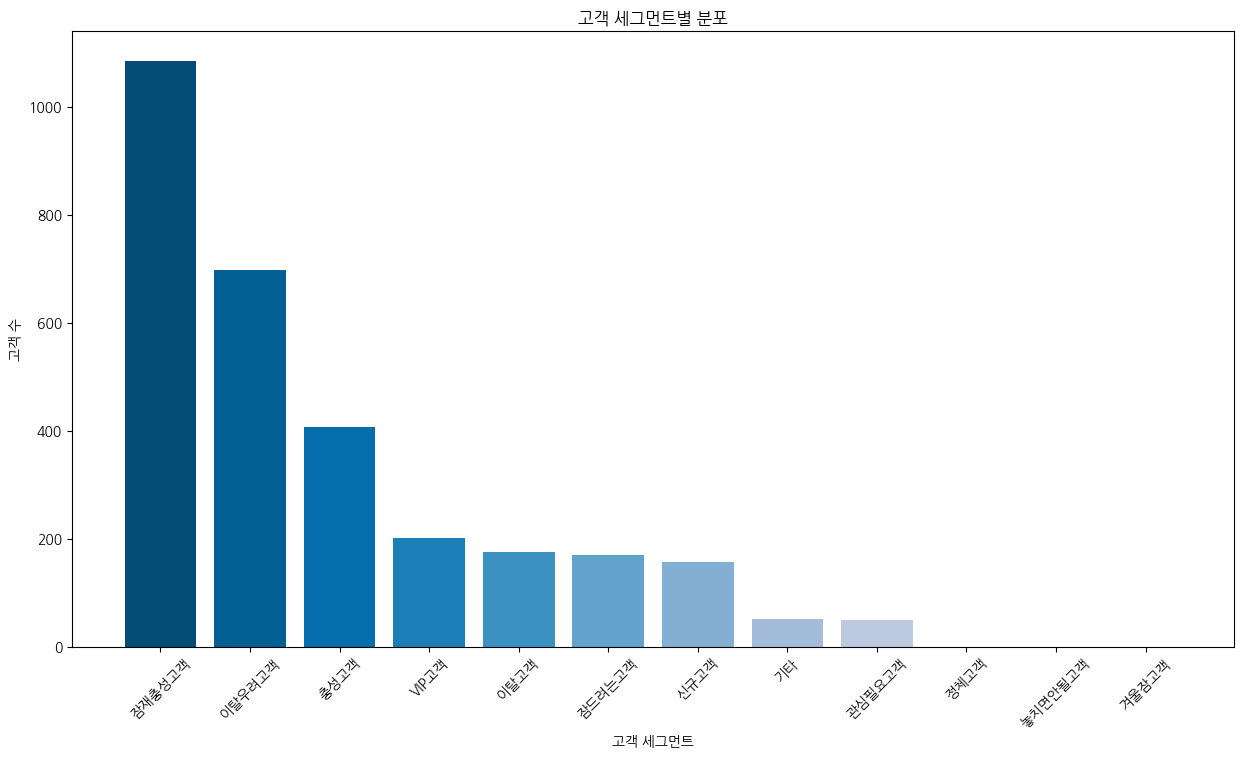

In [42]:
# 세그먼트별 고객 수를 내림차순으로 정렬
segment_counts_sorted_df = segment_counts_df.sort_values(by='Count', ascending=False)

palette = sns.color_palette('PuBu',  len(segment_counts_sorted_df))
palette.reverse()

# 바 그래프 시각화
plt.figure(figsize=(15, 8))
plt.bar(segment_counts_sorted_df['Segment'], segment_counts_sorted_df['Count'], color=palette)
plt.title('고객 세그먼트별 분포')
plt.xlabel('고객 세그먼트')
plt.ylabel('고객 수')
plt.xticks(rotation=45)
plt.show()



In [26]:
rfm_data

,idUser,OrderDT,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score,Customer_Segment
0,U10001,2023-12-27 08:25:54,4,69,5968480,4,4,4,444,VIP고객
1,U10002,2023-12-06 10:16:48,25,54,4595890,1,2,1,121,기타
2,U10003,2023-12-23 21:09:58,8,53,5110930,3,2,2,322,잠재충성고객
3,U10004,2023-12-05 20:24:04,26,33,2641890,1,1,1,111,이탈고객
4,U10005,2023-11-20 12:40:36,41,79,6920530,1,4,4,144,이탈우려고객
...,...,...,...,...,...,...,...,...,...,...
2995,U12996,2023-12-29 18:56:12,2,20,2256990,4,1,1,411,잠재충성고객
2996,U12997,2023-12-26 20:27:53,5,67,5999100,3,3,4,334,충성고객
2997,U12998,2023-11-27 19:51:55,34,56,5318240,1,2,3,123,이탈우려고객
2998,U12999,2023-12-27 10:22:26,4,55,5321330,4,2,3,423,잠재충성고객


In [37]:
df = pd.merge(order_user_item, rfm_data[['idUser','Customer_Segment']])

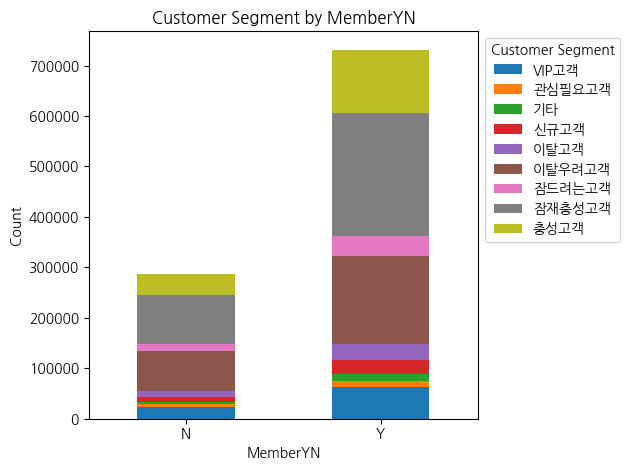

In [46]:
# MemberYN 별 Customer_Segment 빈도 계산
segment_counts = df.groupby(['MemberYN', 'Customer_Segment']).size().unstack()

# 그래프 그리기
segment_counts.plot(kind='bar', stacked=True)
plt.title('Customer Segment by MemberYN')
plt.xlabel('MemberYN')
plt.ylabel('Count')
plt.xticks(rotation=0)  # x축 레이블 회전
plt.legend(title='Customer Segment', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

In [50]:
segment_counts

Customer_Segment,VIP고객,관심필요고객,기타,신규고객,이탈고객,이탈우려고객,잠드려는고객,잠재충성고객,충성고객
MemberYN,,,,,,,,,
N,22739,7311,3010,10196,12409,78710,14732,95545,42918
Y,63111,12318,13121,28159,30615,175875,39798,243911,124437
